<a href="https://colab.research.google.com/github/Tsqsdk/Classify-Gender-in-Masked-Face-Photo-Using-CNN/blob/main/Classify_Gender_in_Masked_Face_Photo_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import tensorflow as tf  # Importing the TensorFlow library for building and training neural networks.
from tensorflow.keras import models, layers  # Importing modules for creating and managing Keras models and layers.
import matplotlib.pyplot as plt  # Importing Matplotlib for data visualization, especially plotting graphs.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importing a class for real-time data augmentation on image data.
import os  # Importing the 'os' module for interacting with the operating system, like handling file paths.
from tensorflow import keras  # Importing Keras, a high-level API for building and training neural networks.
import numpy as np  # Importing NumPy for numerical operations, especially handling arrays.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report  # Importing tools for evaluating classification models using a confusion matrix.
# Importing a function to generate a text report showing the main classification metrics.
import pandas as pd  # Importing Pandas for data manipulation and analysis using DataFrames.
import random  # Importing the 'random' module for generating random numbers.
from tensorflow.keras.preprocessing import image  # Importing modules for image preprocessing, like loading and manipulating images.

In [ ]:
import kagglehub
path = kagglehub.dataset_download("user/gender")
print("Path to dataset files:", path)

In [ ]:
# Define paths to training and testing data
train_directory = '/root/.cache/kagglehub/datasets/user/gender/versions/1/GenderWithMask/Training'
test_directory = '/root/.cache/kagglehub/datasets/user/gender/versions/1/GenderWithMask/Validation'

In [ ]:
# Function to create a dataframe from image data
def create_dataframe(data_path):
    filepaths = []  # Initialize an empty list to store image filepaths.
    labels = []   # Initialize an empty list to store image labels.

    for fold in os.listdir(data_path):  # Iterate through subfolders (classes) in the data directory.
        f_path = os.path.join(data_path, fold)  # Create the full path to the subfolder.
        if os.path.isdir(f_path):  # Check if the item is a directory (subfolder).
            imgs = os.listdir(f_path)  # Get a list of images within the subfolder.
            for img in imgs:  # Iterate through images in the subfolder.
                img_path = os.path.join(f_path, img)  # Create the full path to the image.
                filepaths.append(img_path)  # Add the image path to the filepaths list.
                labels.append(fold)  # Add the subfolder name (label) to the labels list.

    fseries = pd.Series(filepaths, name='Filepaths')  # Create a Pandas Series from the filepaths list.
    lseries = pd.Series(labels, name='Labels')  # Create a Pandas Series from the labels list.
    return pd.concat([fseries, lseries], axis=1)  # Concatenate the two Series to create a DataFrame.

In [ ]:
train_df = create_dataframe(train_directory)  # Create a DataFrame for the training data.
test_df = create_dataframe(test_directory)  # Create a DataFrame for the testing data.

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1].
    rotation_range=40,  # Apply random rotations up to 40 degrees.
    width_shift_range=0.2,  # Apply random horizontal shifts.
    height_shift_range=0.2,  # Apply random vertical shifts.
    shear_range=0.2,  # Apply random shearing transformations.
    zoom_range=0.2,  # Apply random zooming.
    horizontal_flip=True,  # Randomly flip images horizontally.
    fill_mode='nearest'  # Fill in missing pixels using the nearest neighbor method.
)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values for the test data.

In [ ]:
# Create data generators for training and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,  # Use the training DataFrame.
    x_col='Filepaths',  # Column containing image filepaths.
    y_col='Labels',  # Column containing image labels.
    target_size=(224, 224),  # Resize images to 224x224 pixels.
    batch_size=32,  # Set the batch size for training.
    class_mode='binary',  # Set the class mode to binary for binary classification.
    shuffle=True,  # Shuffle the training data.
    seed=42  # Set a random seed for reproducibility.
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Use the testing DataFrame.
    x_col='Filepaths',  # Column containing image filepaths.
    y_col='Labels',  # Column containing image labels.
    target_size=(224, 224),  # Resize images to 224x224 pixels.
    batch_size=32,  # Set the batch size for testing.
    class_mode='binary',  # Set the class mode to binary for binary classification.
    shuffle=False  # Do not shuffle the testing data.
)

Found 4800 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


In [ ]:
# Define and compile the model
input_shape = (224, 224, 3)  # Input shape for the model.
n_classes = len(train_generator.class_indices)  # Number of classes.

model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',  # Use binary cross-entropy loss for binary classification.
    optimizer=tf.optimizers.Adam(),  # Use the Adam optimizer.
    metrics=['accuracy']  # Track accuracy as a metric.
)

model.summary()  # Print a summary of the model architecture.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 32)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 36, 36, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,809 (10.50 MB)

 Trainable params: 2,751,809 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,  # Use the training data generator.
    batch_size=32,  # Set the batch size.
    validation_data=test_generator,  # Use the testing data generator for validation.
    epochs=5  # Train for 5 epochs.
)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.8409 - loss: 0.3563 - val_accuracy: 0.8508 - val_loss: 0.3801
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 381ms/step - accuracy: 0.8218 - loss: 0.3688 - val_accuracy: 0.8675 - val_loss: 0.3257
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - accuracy: 0.8462 - loss: 0.3355 - val_accuracy: 0.8525 - val_loss: 0.3259
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 378ms/step - accuracy: 0.8394 - loss: 0.3542 - val_accuracy: 0.8517 - val_loss: 0.3612
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 377ms/step - accuracy: 0.8398 - loss: 0.3479 - val_accuracy: 0.8650 - val_loss: 0.3195


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


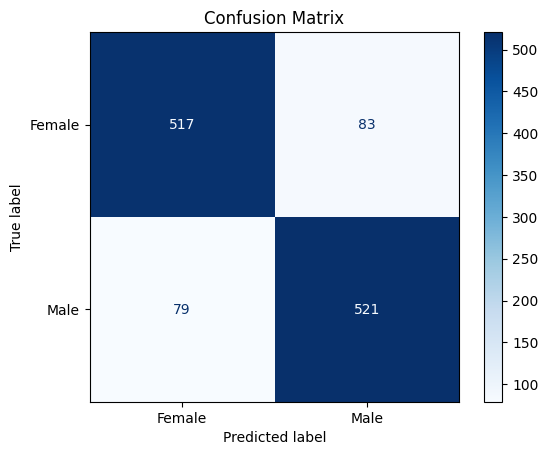

In [ ]:
# Evaluate the model using a confusion matrix
predictions = model.predict(test_generator)  # Get predictions on the test data.

predicted_classes = (predictions > 0.5).astype(int)  # Threshold predictions for binary classification.

true_classes = test_generator.classes  # Get the true labels for the test data.

cm = confusion_matrix(true_classes, predicted_classes)  # Calculate the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)  # Create a ConfusionMatrixDisplay object.
disp.plot(cmap=plt.cm.Blues)  # Plot the confusion matrix.

plt.title("Confusion Matrix")  # Set the title of the plot.
plt.show()  # Show the plot.

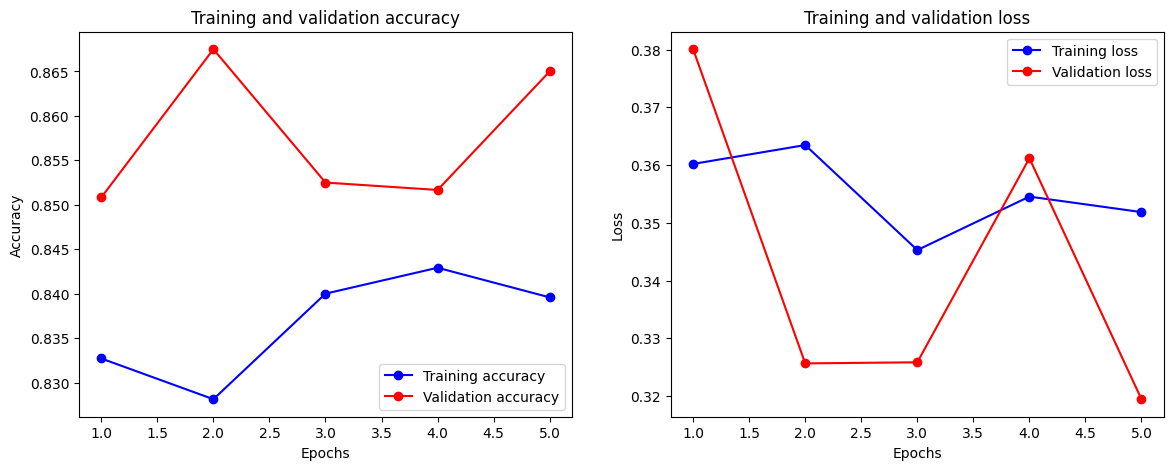

In [ ]:
# Function to plot accuracy and loss curves
def plot_accuracy_loss(history):
    acc = history.history['accuracy']  # Get training accuracy values.
    val_acc = history.history['val_accuracy']  # Get validation accuracy values.
    loss = history.history['loss']  # Get training loss values.
    val_loss = history.history['val_loss']  # Get validation loss values.
    epochs = range(1, len(acc) + 1)  # Generate a range of epoch numbers.

    plt.figure(figsize=(14, 5))  # Create a figure with a specific size.

    plt.subplot(1, 2, 1)  # Create a subplot for accuracy.
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')  # Plot training accuracy.
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')  # Plot validation accuracy.
    plt.title('Training and validation accuracy')  # Set the title of the subplot.
    plt.xlabel('Epochs')  # Set the x-axis label.
    plt.ylabel('Accuracy')  # Set the y-axis label.
    plt.legend()  # Display the legend.

    plt.subplot(1, 2, 2)  # Create a subplot for loss.
    plt.plot(epochs, loss, 'bo-', label='Training loss')  # Plot training loss.
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # Plot validation loss.
    plt.title('Training and validation loss')  # Set the title of the subplot.
    plt.xlabel('Epochs')  # Set the x-axis label.
    plt.ylabel('Loss')  # Set the y-axis label.
    plt.legend()  # Display the legend.

    plt.show()  # Show the plot.

plot_accuracy_loss(history)  # Call the function to plot the curves.

In [ ]:
# Generate a classification report
test_generator.reset()  # Reset the test generator.
predictions = model.predict(test_generator)  # Get predictions on the test data.
predicted_classes = (predictions > 0.5).astype(int)  # Threshold predictions for binary classification.
true_classes = test_generator.classes  # Get the true labels for the test data.
class_labels = list(test_generator.class_indices.keys())  # Get class labels.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)  # Generate the classification report.
print(report)  # Print the classification report.

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
              precision    recall  f1-score   support

      Female       0.85      0.86      0.85       600
        Male       0.86      0.85      0.85       600

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



In [ ]:
# Evaluate the model and print accuracy
scores = model.evaluate(test_generator)  # Evaluate the model on the test data.
print(f'Accuracy: {scores[1]*100}%')  # Print the accuracy.

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8572 - loss: 0.3296
Accuracy: 85.33333539962769%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


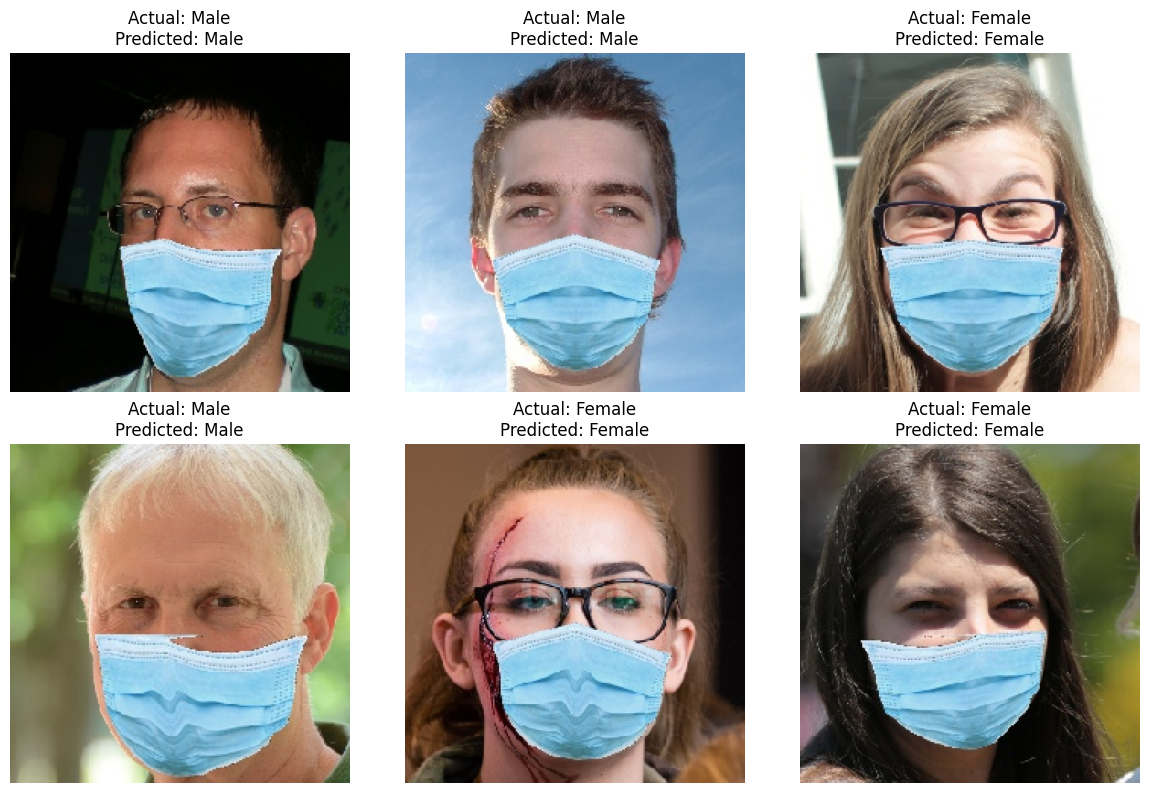

In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Loads an image from a file, preprocesses it, and returns it as a NumPy array.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired size of the image (width, height).

    Returns:
        np.ndarray: Preprocessed image as a NumPy array.
    """
    img = tf.keras.utils.load_img(img_path, target_size=target_size)  # Load the image.
    img_array = tf.keras.utils.img_to_array(img)  # Convert the image to a NumPy array.
    img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size.
    img_array /= 255.0  # Rescale pixel values to the range [0, 1].
    return img_array  # Return the preprocessed image.

# Make predictions on random images and display them
random_indices = random.sample(range(len(test_df)), 6)  # Generate random indices to select images.
random_images_paths = test_df.iloc[random_indices]['Filepaths'].tolist()  # Get the filepaths of the selected images.
random_images_labels = test_df.iloc[random_indices]['Labels'].tolist()  # Get the true labels of the selected images.
images = [load_and_preprocess_image(img_path) for img_path in random_images_paths]  # Load and preprocess the selected images.
images = np.vstack(images)  # Stack the images vertically.
predictions = model.predict(images)  # Get predictions on the images.
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Threshold predictions for binary classification.
class_labels = list(test_generator.class_indices.keys())  # Get class labels.
predicted_labels = [class_labels[idx] for idx in predicted_classes]  # Get predicted labels.

plt.figure(figsize=(12, 8))  # Create a figure with a specific size.
for i, (img_path, actual_label) in enumerate(zip(random_images_paths, random_images_labels)):  # Iterate through the selected images and their labels.
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))  # Load the image.
    plt.subplot(2, 3, i + 1)  # Create a subplot for the image.
    plt.imshow(img)  # Display the image.
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_labels[i]}")  # Set the title of the subplot.
    plt.axis('off')  # Turn off the axes.
plt.tight_layout()  # Adjust subplot parameters for a tight layout.
plt.show()  # Show the plot.